# Project 3 titanic survival prediction

### Import library

In [2]:
library(tidyverse)
library(magrittr)
library(stringr)
library("e1071")

─ Attaching packages ──────────────────── tidyverse 1.2.1 ─
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
─ Conflicts ───────────────────── tidyverse_conflicts() ─
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



### 1. 處理 'boat' 欄

In [35]:
# read data and filter out those 'survived' are NA
transform
titanicTrain = read_csv("titanicTrain.csv")
titanicTrain.surv.nona <- filter(titanicTrain, !is.na(survived))
titanicTrain.surv.withna <- titanicTrain

function (`_data`, ...) 
UseMethod("transform")
<bytecode: 0x7fbacfb1f110>
<environment: namespace:base>

Parsed with column specification:
cols(
  pclass = col_integer(),
  survived = col_integer(),
  name = col_character(),
  sex = col_character(),
  age = col_double(),
  sibsp = col_integer(),
  parch = col_integer(),
  ticket = col_character(),
  fare = col_double(),
  cabin = col_character(),
  embarked = col_character(),
  boat = col_character(),
  body = col_integer(),
  home.dest = col_character()
)


In [4]:
# is.boat is powerful!
titanicTrain.surv.nona %>% mutate(is.boat = !is.na(boat)) %>% 
  group_by(is.boat,survived) %<>% summarise(m=n())%>% mutate(ratio = paste0(round(m/(569+14+8+409)*100, 2), "%"))

is.boat,survived,m,ratio
FALSE,0,569,56.9%
FALSE,1,14,1.4%
TRUE,0,8,0.8%
TRUE,1,409,40.9%


In [5]:
titanicTrain.surv.withna %>% mutate(is.boat = !is.na(boat)) %>% 
  group_by(is.boat,survived) %<>% summarise(m=n()) %>% mutate(ratio = paste0(round(m/(569+14+310+8+409)*100, 2), "%"))

is.boat,survived,m,ratio
FALSE,0,569,43.44%
FALSE,1,14,1.07%
FALSE,NA,310,23.66%
TRUE,0,8,0.61%
TRUE,1,409,31.22%


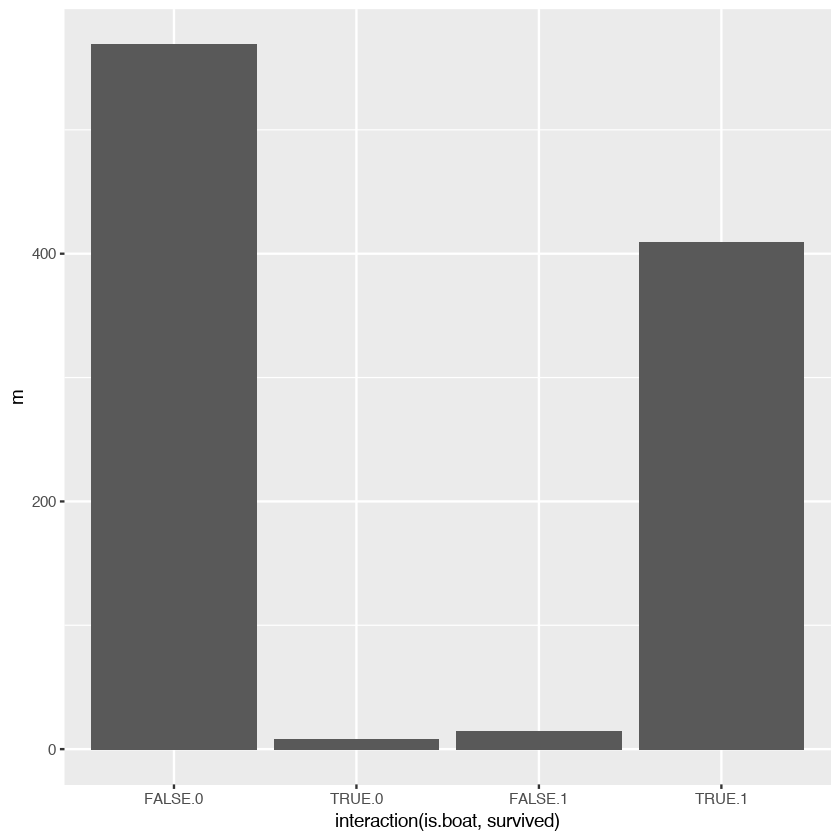

In [6]:
# whether is on the boat is a dominant factor.
titanicTrain.surv.nona %>% mutate(is.boat = !is.na(boat)) %>% 
  group_by(is.boat,survived) %>% summarise(m=n()) %>% 
  ggplot(mapping = aes(interaction(is.boat,survived),m)) + geom_col()

由上述結果可以看出是否上救生艇與是否生存具有決定性的影響因素。以是否上船為基準來預測是否生存（去除survived缺乏資料者），可發現預測錯誤率僅為 2.2%，準確率極高，基本上可以直接以使否上船來做為是否生存的預測模型。

此外我們發現，沒有上船的，有310個人的survived 缺乏資料，或許是因為失蹤。不過單就「**預測上船者是存活的**」而言，預測的正確率為98.1%

### 2.處理 'sex' ＊ 'pclass'

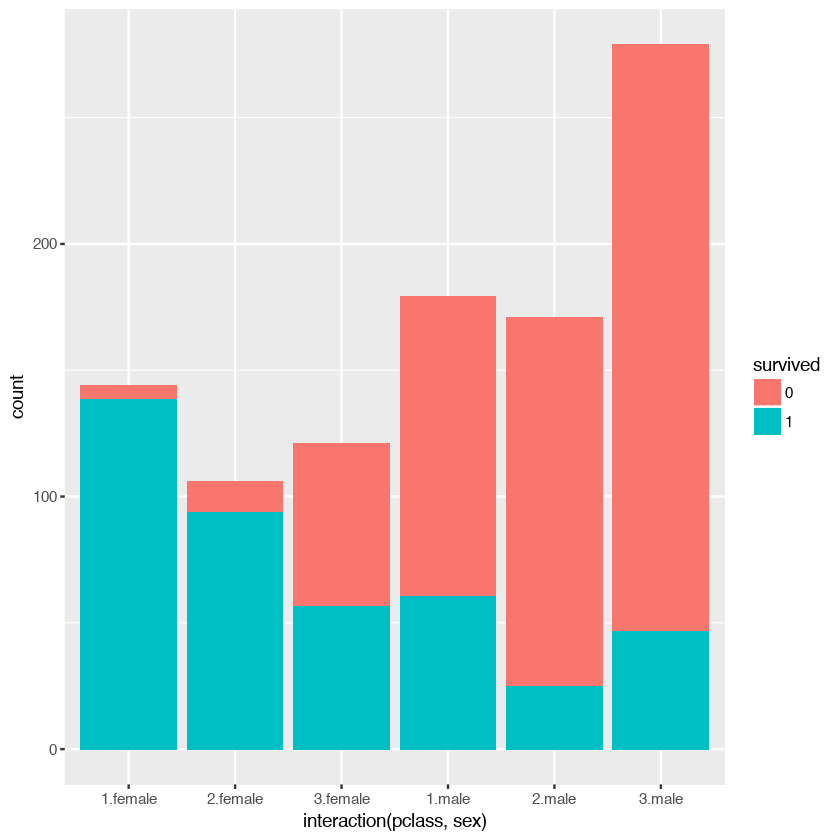

In [7]:
# sex * pclass is powerful too 
titanicTrain.surv.nona %>% transform(survived = as.factor(survived)) %>% 
  group_by(pclass,sex,survived) %>% 
  ggplot(mapping = aes(interaction(pclass,sex),fill = survived)) + geom_bar()

Warning message:
“Removed 1 rows containing missing values (position_stack).”

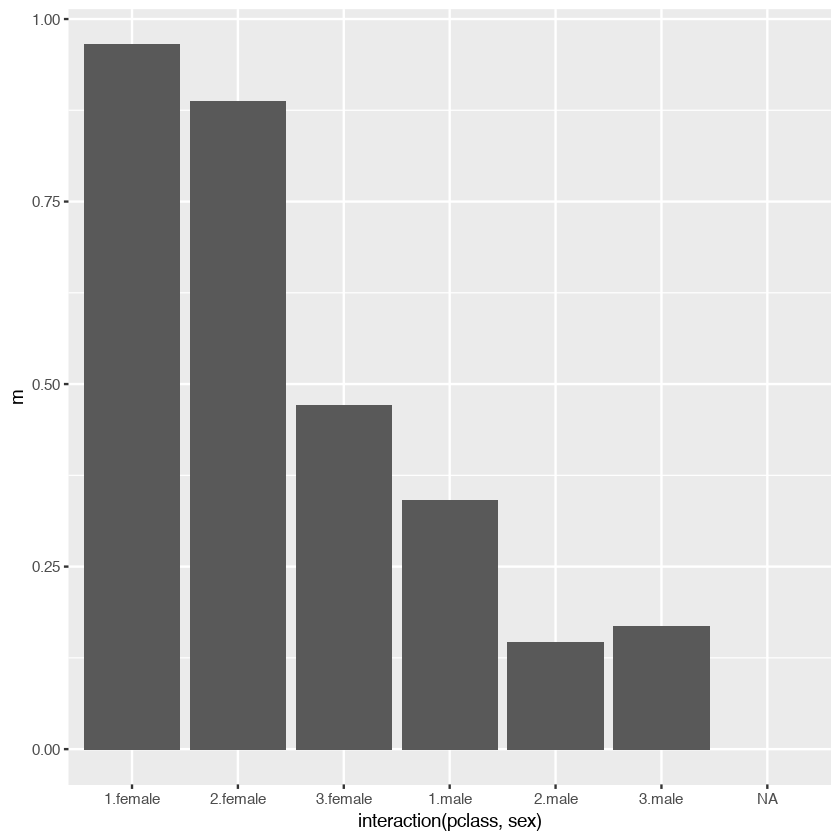

In [11]:
titanicTrain.surv.withna %>% 
  group_by(pclass,sex) %>% summarise(m = sum(survived)/length(survived)) %>% 
  ggplot(mapping = aes(interaction(pclass,sex),m)) + geom_col()

如果以性別以及艙等來預測是否生存，我們可以發現，女性頭等艙的存活率最高，隨著艙等的下降，期存活率開始下降。男性則是存活率皆低於37.5%

### 3. nGroup

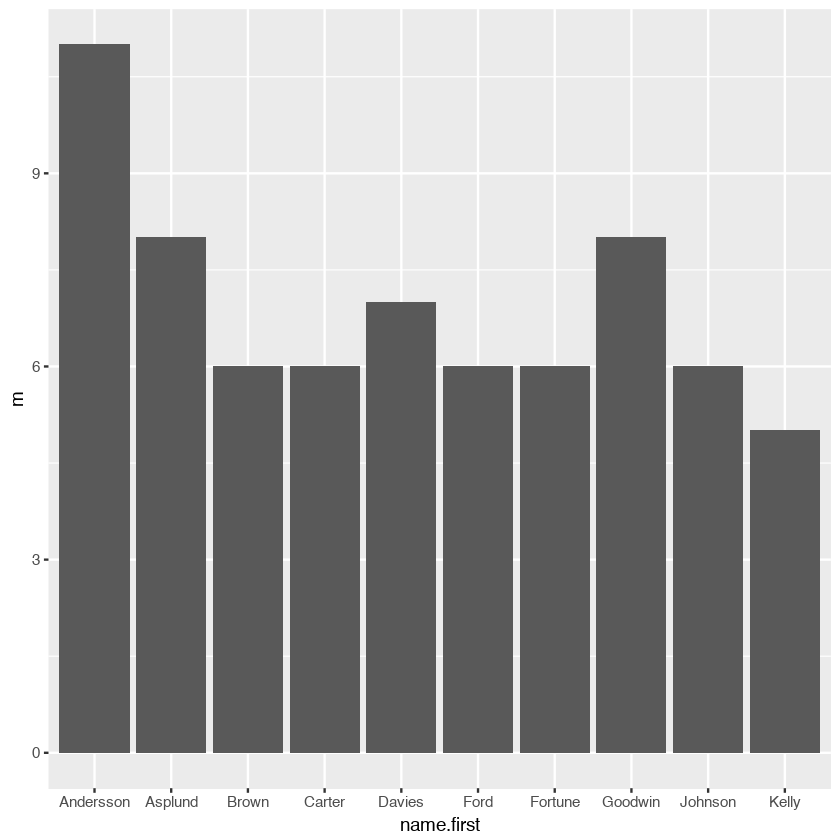

In [43]:
# generate first name column
titanicTrain.surv.nona$name.first = 
  strsplit(titanicTrain.surv.nona$name,",") %>% 
  do.call(rbind,.) %>% .[,1] 

titanicTrain.surv.nona %>% group_by(name.first) %>% summarise(m=n()) %>% 
  arrange(desc(m)) %>% head(10) %>% 
  ggplot(mapping = aes(name.first,m)) + geom_col()

用逗點切出 first name，觀察一下前幾高的名字人數

In [41]:
# considering ticket
ticket.group = titanicTrain.surv.nona %>% group_by(ticket) %>% summarise(ticket.group=n())
titanicTrain.surv.nona %<>% left_join(ticket.group)

Joining, by = c("ticket", "ticket.group")


新增一個欄位，計算相同 ticket 的人數

In [45]:
# considering first name
name.group = titanicTrain.surv.nona %>% group_by(name.first) %>% summarise(name.group=n())
titanicTrain.surv.nona %<>% left_join(name.group)

Joining, by = "name.first"


新增一個欄位，計算相同 first name 的人數

In [46]:
# considering 
home.group = titanicTrain.surv.nona %>% filter((ticket.group != 1)&(ticket.group != name.group)) %>% 
  group_by(ticket,home.dest) %>% summarise(home.group=n())
titanicTrain.surv.nona %<>% left_join(home.group)

Joining, by = c("ticket", "home.dest")


新增一個欄位，計算相同 home.dest 的人數

In [50]:
# generate ngroup
titanicTrain.surv.nona$index = 1:nrow(titanicTrain.surv.nona)
df1 = titanicTrain.surv.nona %>% filter(ticket.group == (name.group | home.group)) %>% 
  mutate(ngroup = ticket.group) %>% select(index,ngroup)

df2 = titanicTrain.surv.nona %>% filter((ticket.group != home.group)&(name.group == home.group)) %>% 
  mutate(ngroup = name.group) %>% select(index,ngroup)

df3 = df1 %>% full_join(df2)
 
titanicTrain.surv.nona %<>% left_join(df3)
#titanicTrain.surv.nona %>% View

Joining, by = c("index", "ngroup")
Joining, by = c("index", "ngroup")


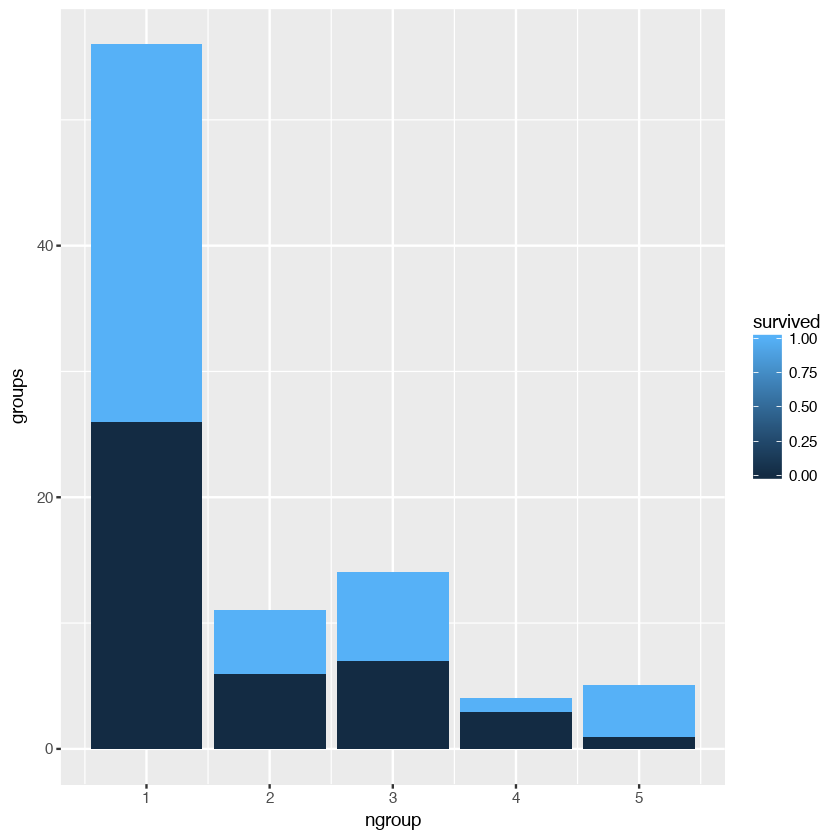

In [51]:
# test ngroup
titanicTrain.surv.nona %>% filter(!is.na(ngroup)) %>% 
  group_by(ngroup,survived) %>% summarise(groups=n()) %>% 
  ggplot(mapping = aes(ngroup,groups,fill = survived)) + geom_col()

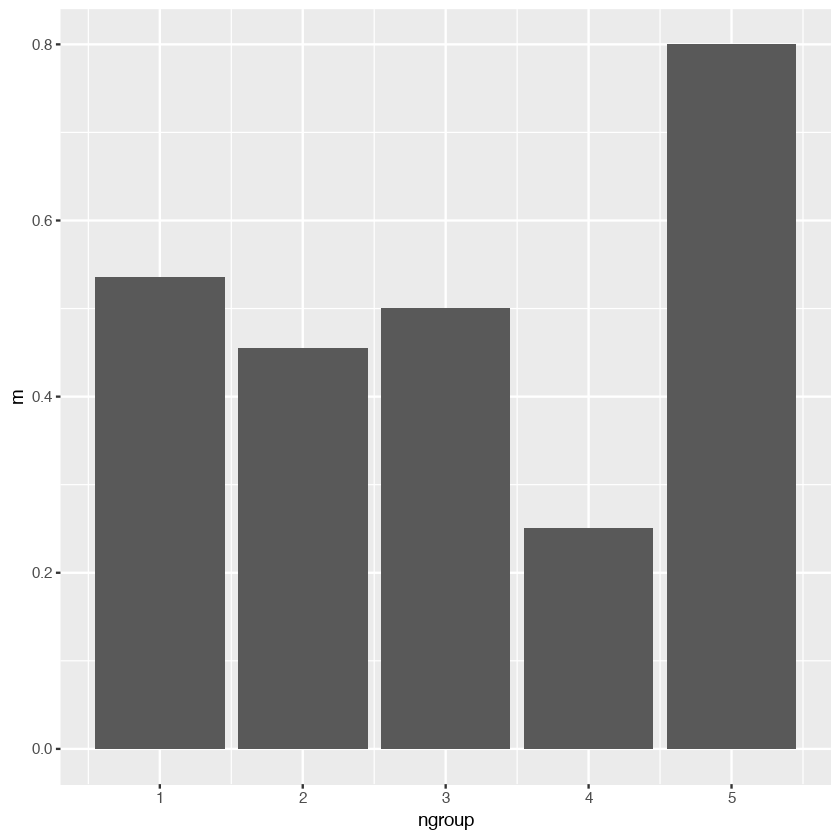

In [52]:
titanicTrain.surv.nona %>% filter(!is.na(ngroup)) %>% 
  group_by(ngroup) %>% summarise(m=sum(survived)/length(ngroup)) %>% 
  ggplot(mapping = aes(ngroup,m)) + geom_col()

這次嘗試用三種資訊來推估所屬群體的人數，分別是姓、票號、目的地（以票號先分群後再以目的地分群）。
而五人群組的存活率相當高，四人群組的存活率反而比更小的群組低。
但這樣的篩選方法並不是很好，因為單人乘客的數量會被低估，或是有些多人群組會被切割。

# Explore ML model

### 首先先整理資料

In [7]:
# drop rows that is all nan
titanicTrain.row.no.na <- titanicTrain.surv.withna[rowSums(is.na(titanicTrain.surv.withna)) != ncol(titanicTrain.surv.withna),]

In [8]:
# add a column with first_name
titanicTrain.row.no.na["first_name"] <- str_split_fixed(titanicTrain.row.no.na$name, ',', 3)[,1]

In [9]:
# fill nan with default values
titanicTrain.row.no.na$age[is.na(titanicTrain.row.no.na$age)] <- '0'
titanicTrain.row.no.na$cabin[is.na(titanicTrain.row.no.na$cabin)]  <- 'nan'
titanicTrain.row.no.na$embarked[is.na(titanicTrain.row.no.na$embarked)]  <- 'nan'
titanicTrain.row.no.na$boat[is.na(titanicTrain.row.no.na$boat)]  <- 'nan'
titanicTrain.row.no.na$body[is.na(titanicTrain.row.no.na$body)]  <- '0'

In [10]:
titanicTrain.final <- titanicTrain.row.no.na[,c("pclass", "survived", "first_name", "sex", "age", "sibsp", "parch", "ticket", "fare", "cabin", "embarked", "boat", "body")]

In [11]:
head(titanicTrain.final,10)

pclass,survived,first_name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body
1,1,Allen,female,29,0,0,24160,211.3375,B5,S,2,0
1,1,Allison,male,0.9167,1,2,113781,151.5500,C22 C26,S,11,0
1,0,Allison,female,2,1,2,113781,151.5500,C22 C26,S,nan,0
1,0,Allison,male,30,1,2,113781,151.5500,C22 C26,S,nan,135
1,0,Allison,female,25,1,2,113781,151.5500,C22 C26,S,nan,0
1,1,Anderson,male,48,0,0,19952,26.5500,E12,S,3,0
1,1,Andrews,female,63,1,0,13502,77.9583,D7,S,10,0
1,0,Andrews,male,39,0,0,112050,0.0000,A36,S,nan,0
1,1,Appleton,female,53,2,0,11769,51.4792,C101,S,D,0
1,0,Artagaveytia,male,71,0,0,PC 17609,49.5042,nan,C,nan,22


In [12]:
titanicQestion <- read_csv("titanicQuestion.csv")

# drop rows that is all nan
titanicQestion <- titanicQestion[rowSums(is.na(titanicQestion)) != ncol(titanicQestion),]

# add a column with first_name
titanicQestion["first_name"] <- str_split_fixed(titanicQestion$name, ',', 3)[,1]
# fill nan with default values
titanicQestion$age[is.na(titanicQestion$age)] <- '0'
titanicQestion$cabin[is.na(titanicQestion$cabin)]  <- 'nan'
titanicQestion$embarked[is.na(titanicQestion$embarked)]  <- 'nan'
titanicQestion$boat[is.na(titanicQestion$boat)]  <- 'nan'
titanicQestion$body[is.na(titanicQestion$body)]  <- '0'

titanicQestion.final <- titanicQestion[,c("pclass", "survived", "first_name", "sex", "age", "sibsp", "parch", "ticket", "fare", "cabin", "embarked", "boat", "body")]

Parsed with column specification:
cols(
  pclass = col_integer(),
  survived = col_character(),
  name = col_character(),
  sex = col_character(),
  age = col_double(),
  sibsp = col_integer(),
  parch = col_integer(),
  ticket = col_character(),
  fare = col_double(),
  cabin = col_character(),
  embarked = col_character(),
  boat = col_character(),
  body = col_integer(),
  home.dest = col_character()
)


In [13]:
head(titanicQestion.final, 10)

pclass,survived,first_name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body
3,NA,McCormack,male,0,0,0,367228,7.7500,nan,Q,nan,0
3,NA,McCoy,female,0,2,0,367226,23.2500,nan,Q,16,0
3,NA,McCoy,female,0,2,0,367226,23.2500,nan,Q,16,0
3,NA,McCoy,male,0,2,0,367226,23.2500,nan,Q,16,0
3,NA,McDermott,female,0,0,0,330932,7.7875,nan,Q,13,0
3,NA,McEvoy,male,0,0,0,36568,15.5000,nan,Q,nan,0
3,NA,McGovern,female,0,0,0,330931,7.8792,nan,Q,13,0
3,NA,McGowan,female,15,0,0,330923,8.0292,nan,Q,nan,0
3,NA,McGowan,female,35,0,0,9232,7.7500,nan,Q,nan,0
3,NA,McMahon,male,0,0,0,370372,7.7500,nan,Q,nan,0


In [14]:
# answer (Y in training set)
Y <- titanicTrain.final$survived

In [15]:
# drop survived
data <- titanicTrain.final[,!(names(titanicTrain.final) %in% c("survived"))]
test_data <- titanicQestion.final[,!(names(titanicQestion.final) %in% c("survived"))]

In [16]:
# data encoding
data$first_name <- as.integer(as.factor(data$first_name))
data$sex <- as.integer(as.factor(data$sex))
data$ticket <- as.integer(as.factor(data$ticket))
data$cabin <- as.integer(as.factor(data$cabin))
data$embarked <- as.integer(as.factor(data$embarked))
data$boat <- as.integer(as.factor(data$boat))
data$body <- as.integer(as.factor(data$body))

In [17]:
# test_data encoding
test_data$first_name <- as.integer(as.factor(test_data$first_name))
test_data$sex <- as.integer(as.factor(test_data$sex))
test_data$ticket <- as.integer(as.factor(test_data$ticket))
test_data$cabin <- as.integer(as.factor(test_data$cabin))
test_data$embarked <- as.integer(as.factor(test_data$embarked))
test_data$boat <- as.integer(as.factor(test_data$boat))
test_data$body <- as.integer(as.factor(test_data$body))

In [18]:
model <- svm(formula = Type~., data = data )

ERROR: Error in eval(predvars, data, env): 找不到物件 'Type'


In [20]:
svm_model <- svm(Species ~ ., data=data.frame(data))
summary(svm_model)

ERROR: Error in eval(predvars, data, env): 找不到物件 'Species'
